### Course Announcements

**Due Friday (11:59 PM)**
- D7
- Q7
- Checkpoint #2: EDA
- Weekly Project Survey (optional)

**Notes**
- Prof Ellis' Office hours (the rest of the quarter)
    - Weeks 8-10: Wed 1:30-2:30 PM; Fri 10-11 AM

**Mid-Course Survey Summary** (N=237)

- Least Liked:
    - Too much work due on Fridays!
    - Quizzes (feel too high stakes!)
    - Discussion labs are too long!
    - Ah! Project! (it's a lot! had to change topics!)
    - Remote learning (generally, and for the project)

**Planning ahead** & Changes:

- Wk 8: Q7<sup>+</sup>, D7<sup>*</sup>, Checkpoint #2: EDA
- Wk 9: Q8<sup>+</sup>, D8<sup>*</sup>, A4
- Wk 10: Q9<sup>+</sup>, ~D9~
- Finals Week: Final Report, Final Video, Project Survey

<sup>*</sup> will shorten  
<sup>+</sup> will make more straightforward

# Machine Learning in Python

- Tools: scikit-learn (`sklearn`)
    - Data Partitioning
    - Feature selection
    - Modeling: SVM
    - Model Assessment


For more reading on scikit-learn (`sklearn`) and machine learning in Python: https://scikit-learn.org/stable/index.html

# Machine Learning: General Steps

1. Data Partitioning
2. Feature Selection
3. Model
4. Model Assessment

## Setup

In [2]:
# import ds/plotting packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import nltk package 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# import random for randomizing
import random

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# scikit-learn imports
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [ ]:
# Uncomment if you need to download the NLTK English tokenizer and the stopwords of all languages
# nltk.download('punkt')
# nltk.download('stopwords')

# Example: Class Responses

## Data

Student responses on COGS 108 Mid-course survey to the following two questions: 

- What have you enjoyed MOST about COGS 108 so far? Please explain.
- What have you enjoyed LEAST about COGS 108 so far? Please explain.

In [3]:
# read data in
# 1 = most; 0 = least
df = pd.read_csv('https://raw.githubusercontent.com/shanellis/datasets/master/COGS108_ml.csv', encoding="ISO-8859-1")
df.tail()

,response,most_least,quarter
3454,I can't say that there's bad about this course.,0,sp21
3455,"Aside from the lecture time, which can't be he...",0,sp21
3456,"I don't think this is really an issue at all, ...",0,sp21
3457,Nothing in particular,0,sp21
3458,It has been hard making it to lectures in the ...,0,sp21


In [4]:
# randomly sort data frame
df = df.sample(frac=1, random_state=200).reset_index(drop=True)
df.head()

,response,most_least,quarter
0,I don't understand some basic aspects of pushi...,0,fa20
1,Working with my group has been a little frustr...,0,wi21
2,The consistent amount of assignments,0,wi21
3,The lectures are honestly super interesting an...,1,sp19
4,Self-paced lectures,1,fa20


Randomly sorted data frame:
- for selection of training and test set
- will be approximately balanced between outcomes in each

In [5]:
# see how much data we're working with
df.shape

(3459, 3)

### Train, Test, Validate

- We'll train the model on 80% of the responses from the past five quarter's survey
- We'll test the model on the 20% we've held out
- We'll validate the model on this quarter's responses

In [6]:
## Train/Test
df_traintest = df[df['quarter']!='sp21']

## Validation
df_validation = df[df['quarter']=='sp21']

In [7]:
print(df_traintest.shape, df_validation.shape)

(2993, 3) (466, 3)


- train/test
    - Sp19: 631
    - Wi20: 492
    - Sp20: 705
    - Fa20: 551
    - Wi21: 615
- validate:
    - Sp21: 466

#### Clicker Question #1

How well do you think we will be able to predict whether a student comment is a response to what they liked most vs what they liked least in our ***test*** dataset?

- A) Accuracy ~0%
- B) Accuracy ~25%
- C) Accuracy ~50%
- D) Accuracy ~75%
- E) Accuracy ~100%

#### Clicker Question #2

How well do you think we will be able to predict whether a student comment is a response to what they liked most vs what they liked least in our ***validation*** dataset?

- A) Accuracy ~0%
- B) Accuracy ~25%
- C) Accuracy ~50%
- D) Accuracy ~75%
- E) Accuracy ~100%

## Prediction Task: 

**Classify text from students as 'most liked' or 'least liked'**

#### 11 Steps to Prediction:

1. Specify parameters for TF-IDF calculation
2. Calculate TF-IDF from text input (predictors)
3. Extract most or least (outcome)
4. Specify how data will be partitioned
5. Partition the data
6. Train model
7. Predict in training
8. Predict in testing
9. Assess accuracy in training
10. Assess accuracy in test set
11. Assess accuracy in validation set

### Data Processing

Step 1: Determine how you'll convert a collection of raw documents to a matrix of TF-IDF features.

In [8]:
# Create vectorizer & specify parameters
tfidf = TfidfVectorizer(sublinear_tf=True, #apply sublinear TF scaling
                        analyzer='word',   #specify tokenizer
                        max_features=500, # specify max # of features to include
                        tokenizer=word_tokenize)

* sublinear TF scaling - replaces term frequency (TF) with $1 + log(TF)$

Step 2: Generate matrix of TF-IDF features.

In [9]:
# Learn vocabulary and idf, return term-document matrix.
# return an array;our predictor
tfidf_X = tfidf.fit_transform(df_traintest['response']).toarray()

# take a look at the output
print(tfidf_X.shape)

print("min: " , np.min(tfidf_X), '\n',
      "mean: ", np.mean(tfidf_X), '\n',
      "max: ",  np.max(tfidf_X))

(2993, 500)
min:  0.0 
 mean:  0.006827444081791176 
 max:  1.0


In [10]:
## get IDF to visualize
idf = tfidf.idf_
rr = dict(zip(tfidf.fit(df_traintest['response']).get_feature_names(), idf))

token_weight = pd.DataFrame.from_dict(rr, orient='index').reset_index()
token_weight.columns=('token','weight')
token_weight = token_weight.sort_values(by='weight', ascending=False)
token_weight.head() 

,token,weight
398,step,6.606470
423,tests,6.519459
242,itâs,6.519459
249,lab,6.439416
14,2,6.439416


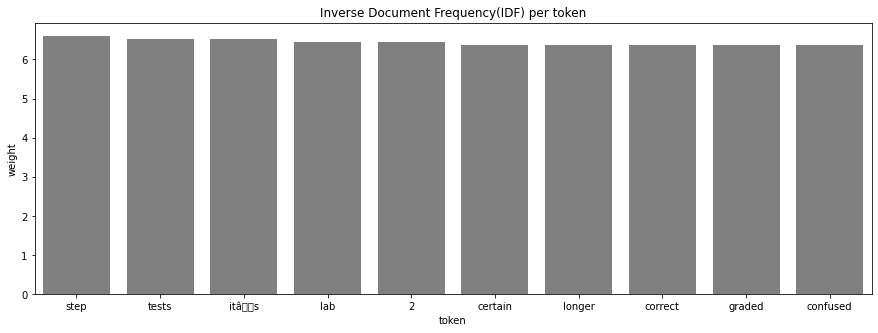

In [11]:
sns.barplot(x='token', 
            y='weight', 
            data=token_weight[0:10], 
            color="gray")            
plt.title("Inverse Document Frequency(IDF) per token")
fig = plt.gcf()
fig.set_size_inches(15,5);

Step 3: Extract outcome variable

In [12]:
# specify outcome variable
tfidf_Y = np.array(df_traintest['most_least'])
tfidf_Y[0:5]

array([0, 0, 0, 1, 1])

## Data Partitioning & Feature Selection

80/20 split

We're going to be looking at the ability of using the text responses to predict whether or not it was something someone liked most or liked least.

Step 4: Determine split in data.

In [13]:
# specify training and test
num_training = int(len(df_traintest)*0.8)
num_testing = len(df_traintest)-num_training

print(num_training, num_testing)

2394 599


Step 5: Split (partition) the data.

In [14]:
# get data
# because rows have been randomized previously
tfidf_train_X = tfidf_X[:num_training]
tfidf_train_Y = tfidf_Y[:num_training]
tfidf_test_X = tfidf_X[num_training:]
tfidf_test_Y = tfidf_Y[num_training:]

#### Clicker Question #3

Looking at the code above and thinking about what we've done so far in this analysis, what is stored in `tfidf_test_Y`?

- A) predictor variable - training data
- B) outcome variable - training data
- C) predictor variable - test data
- D) outcome variable - test data
- E) validation DataFrame

In [15]:
# take a look at the data we're using
print(tfidf_train_X.shape)
tfidf_train_X

(2394, 500)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.22585348, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Model

### SVM: Support Vector Machines

- simple & interpretable machine learning model
- based in linear regression
- classification task
- supervized
    - input: labeled training data
    - model determines hyperplane that best discriminates between categories

### SVM: Tuning Parameters
- **regularization** parameter
    - can determine how this line is drawn
    - can increase accuracy of prediction
    - can lead to overfitting of the data
- **kernel** parameter
    - specifies how to model & transform data
    

For more reading on SVMs using `sklearn`: https://scikit-learn.org/stable/modules/svm.html

### Model Generation
    

Step 6: Generate and train the model.

In [16]:
# uncomment to read documentation for model
SVC?

In [17]:
# function we'll use to run the model
def train_SVM(X, Y, kernel='linear'):
    model = SVC(kernel=kernel)
    model.fit(X, Y)
    return model

In [18]:
# train model
svm_model = train_SVM(tfidf_train_X, tfidf_train_Y)
type(svm_model)

sklearn.svm._classes.SVC

### Training Data

Step 7: Predict in the training data

In [19]:
# predict on training
df_predicted_train_Y = svm_model.predict(tfidf_train_X)
print(df_predicted_train_Y[0:5])
len(df_predicted_train_Y)

[0 0 0 1 1]


2394

In [20]:
# see how many were predicted most vs. least
pd.Series(df_predicted_train_Y).value_counts()

1    1264
0    1130
dtype: int64

### Testing Data

Step 8: Predict in the testing data

In [21]:
# predict on training
df_predicted_test_Y = svm_model.predict(tfidf_test_X)
print(df_predicted_test_Y[0:5])
len(df_predicted_test_Y)

[0 1 1 0 0]


599

In [22]:
# see how many were predicted most vs. least
pd.Series(df_predicted_test_Y).value_counts()

1    311
0    288
dtype: int64

## Accuracy Assessment

- RMSE (continuous)
- Accuracy, Sensitivity, Specificity, AUC
    - TP, TN, FP, FN

**Accuracy** - What % were predicted correctly?  
**Sensitivity (Recall)** - Of those that were positives, what % were predicted to be positive?  ; $\frac {TP}{(TP + FN)}$  
**Specificity** - Of those that were actually negatives, what % were predicted to be negative?  $\frac {TN}{(TN + FP)}$

**Precision (Positive Predictive Value, PPV)** = $\frac {TP}{(TP + FP)}$

- probability that predicted positive truly is positive

### Training Data

Step 9: Assess accuracy in training data

In [23]:
print(classification_report(tfidf_train_Y, df_predicted_train_Y))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1122
           1       0.91      0.91      0.91      1272

    accuracy                           0.90      2394
   macro avg       0.90      0.90      0.90      2394
weighted avg       0.90      0.90      0.90      2394



**support** - the number of occurrences of each class  
**precision (PPV)** - ability of the classifier not to label a positive sample as negative  
**recall (sensitivity)** - ability of the classifer to find all the positive samples


**f1-score** - weighted harmonic mean of the precision and recall; score reaches its best value at 1 and worst score at 0  
**macro average** - averaging the unweighted mean per label  
**weighted average** - averaging the support-weighted mean per label  
**micro average** - averaging the total true positives, false negatives and false positives

In [ ]:
# where 'support' comes from
pd.Series(tfidf_train_Y).value_counts()

### Testing Data

Step 10: Assess accuracy in testing data

In [24]:
print(classification_report(tfidf_test_Y, df_predicted_test_Y))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       303
           1       0.82      0.86      0.84       296

    accuracy                           0.83       599
   macro avg       0.84      0.83      0.83       599
weighted avg       0.84      0.83      0.83       599



#### Clicker Question #4

Given this output, would you use this model to predict whether or not text was something someone liked or disliked about COGS 108?

- A) Yes
- B) No
- C) Unsure

### Validation Data

Step 11: Assess accuracy in validation data

In [25]:
df_validation.head()

,response,most_least,quarter
8,I don't think I have anything I like the least...,0,sp21
10,I love the professor. She is so fun and sweet ...,1,sp21
18,"I don't like using sns, but I guess it's fine ...",0,sp21
24,Nothing in particular,0,sp21
28,Sometimes the quizzes are a little tricky but ...,0,sp21


In [26]:
# the ground truth
tfidf_vaidation_Y = np.array(df_validation['most_least'])

# predicted values from class responses
tfidf_validation_X = tfidf.fit_transform(df_validation['response']).toarray()
df_predicted_validation_Y = svm_model.predict(tfidf_validation_X)

# assess accuracy
print(classification_report(tfidf_vaidation_Y, df_predicted_validation_Y))

              precision    recall  f1-score   support

           0       0.58      0.64      0.61       229
           1       0.62      0.55      0.58       237

    accuracy                           0.60       466
   macro avg       0.60      0.60      0.60       466
weighted avg       0.60      0.60      0.60       466



#### Clicker Question #5

Given this output, would you use this model to predict whether or not text was something someone liked or disliked about COGS 108?

- A) Yes
- B) No
- C) Unsure

### Summary

1. 80:20 Partition
2. Specified TF-IDF as predictor and most/least (0,1) as outcome
3. Trained SVM linear classifier
4. Built model on Training data
5. Predicted in training data and on testing data
6. Assessed overall accuracy

### Approaches For Improvement?

- Data Cleaning/Stemming
- Different Tuning Parameters?
- Cross-Validation?
- Train/Test on all data OR Train only Sp20/Fa20/Wi21 (remote quarters)
- Different Model?